<a href="https://colab.research.google.com/github/Amitroki/ApplProg-5-lab/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%94%D0%BE%D0%B1%D1%80%D0%BE_%D0%BF%D0%BE%D0%B6%D0%B0%D0%BB%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B2_Colaboratory!%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import zipfile
from torchvision import transforms

Передаем наш датасет

In [6]:
from google.colab import files
data_to_load = files.upload()
dataset = files.upload()

Saving annotation.csv to annotation (1).csv


Saving dataset.zip to dataset (1).zip


Меняем представление данных файла csv

In [7]:
df = pd.read_csv('annotation.csv', delimiter=",")
def get_abs_path(row):
  return row['absolute path'].replace('D:\Coding\Python\python', '/content').replace("\\", "/")
df['absolute path'] = df.apply(get_abs_path, axis=1)
df = shuffle(df)
print(df.head(5))

                             absolute path class label  class  width  height  \
1966  /content/dataset/polar_bear/0955.jpg  polar bear      1    115     180   
1048  /content/dataset/polar_bear/0037.jpg  polar bear      1    214     180   
388   /content/dataset/brown_bear/0389.jpg  brown bear      0    264     180   
1855  /content/dataset/polar_bear/0844.jpg  polar bear      1    230     180   
320   /content/dataset/brown_bear/0321.jpg  brown bear      0    122     180   

      channels  
1966         3  
1048         3  
388          3  
1855         3  
320          3  


Перемещаем все необходимые для работы данные в текущую директорию

In [8]:
z = zipfile.ZipFile("/content/dataset.zip", 'r')
z.extractall()
print(os.listdir())

['.config', 'annotation (1).csv', 'dataset (1).zip', 'data.csv', 'dataset', 'annotation.csv', 'dataset.zip', 'sample_data']


Проверим вывод изображений на экран

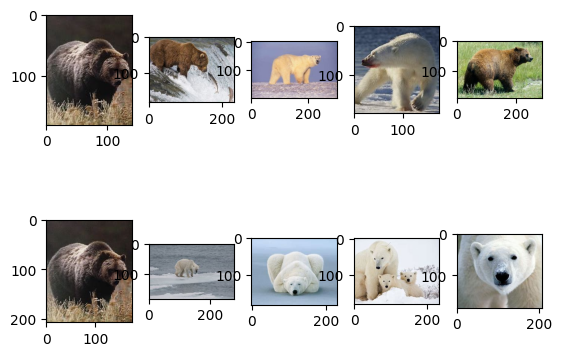

In [12]:
img_list = df['absolute path'].tolist()
lbl_list = df['class'].tolist()
random_idx = np.random.randint(1,len(img_list),size=11)
figure = plt.figure()
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    img = Image.open(img_list[random_idx[i]])
    figure.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()

Разделение на тестовую, валидационную и обучающую выборки

In [13]:
X_train_list = img_list[0 : int(len(img_list) * 0.8)]
X_test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
X_val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]

Y_train_list = lbl_list[0 : int(len(lbl_list) * 0.8)]
Y_test_list = lbl_list[int(len(lbl_list) * 0.8) : int(len(lbl_list) * 0.9)]
Y_val_list = lbl_list[int(len(lbl_list) * 0.9) : int(len(lbl_list))]

print(len(X_train_list ))
print(len(X_test_list))
print(len(X_val_list))

1627
203
204


Хранение загруженных и преобразованных изображений

In [14]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list, lbl_list,transform=None):
        self.file_list = file_list
        self.label_list = lbl_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = self.label_list[idx]
        return img_transformed,label

Формирование набора данных

In [17]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(X_train_list, Y_train_list, transform=fixed_transforms)
test_data = dataset(X_test_list, Y_test_list, transform=fixed_transforms)
val_data = dataset(X_val_list, Y_val_list, transform=fixed_transforms)

Этап аугментации

1627


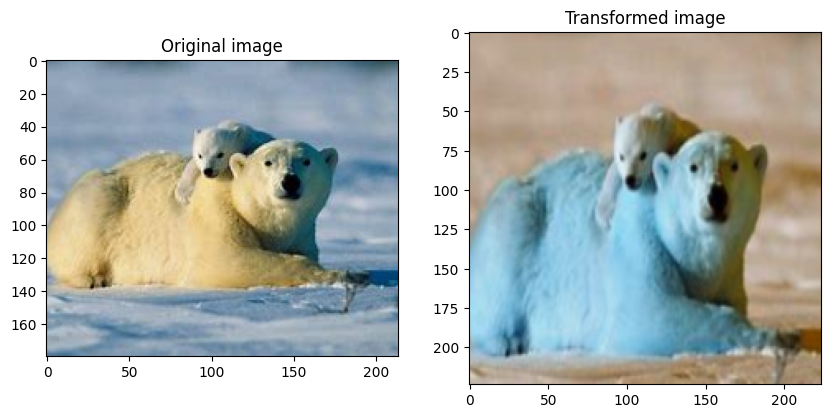

In [19]:
print(len(train_data))
train_data[0][0].shape
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(Image.open(img_list[1]))
plt.subplot(1, 2, 2)
plt.title('Transformed image')
plt.imshow(train_data[1][0].permute(1, 2, 0).numpy()[:, :, ::-1])

CNN

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 3 * 3, 32)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 2)  # 2 класса

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

model = CNN()
model.train()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

Отрисовка графиков

In [22]:
def show_results(epochs, acc, loss, v_acc, v_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="orange", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="orange", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="steelblue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="steelblue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show()

Train Loop

In [24]:
def train_loop(epochs, batch_size, lear):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lear)
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data,
                                            batch_size=batch_size,
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                            batch_size=batch_size,
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)


                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item())
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Этап обучения модели с различными значениями параметров batch size и learnig rate

Epoch : 1, train accuracy : 0.666644811630249, train loss : 0.6536726355552673
Epoch : 1, val_accuracy : 0.8166666626930237, val_loss : 0.5059603452682495
Epoch : 2, train accuracy : 0.8351634740829468, train loss : 0.4296348989009857
Epoch : 2, val_accuracy : 0.8199999928474426, val_loss : 0.4441317021846771
Epoch : 3, train accuracy : 0.8791722059249878, train loss : 0.313557505607605
Epoch : 3, val_accuracy : 0.8533333539962769, val_loss : 0.3210040330886841
Epoch : 4, train accuracy : 0.9068191051483154, train loss : 0.26412415504455566
Epoch : 4, val_accuracy : 0.8566666841506958, val_loss : 0.49287956953048706
Epoch : 5, train accuracy : 0.8971678018569946, train loss : 0.2537098526954651
Epoch : 5, val_accuracy : 0.9500000476837158, val_loss : 0.18139246106147766
Epoch : 6, train accuracy : 0.9152940511703491, train loss : 0.25061312317848206
Epoch : 6, val_accuracy : 0.8633333444595337, val_loss : 0.2878749370574951
Epoch : 7, train accuracy : 0.9128758311271667, train loss : 0

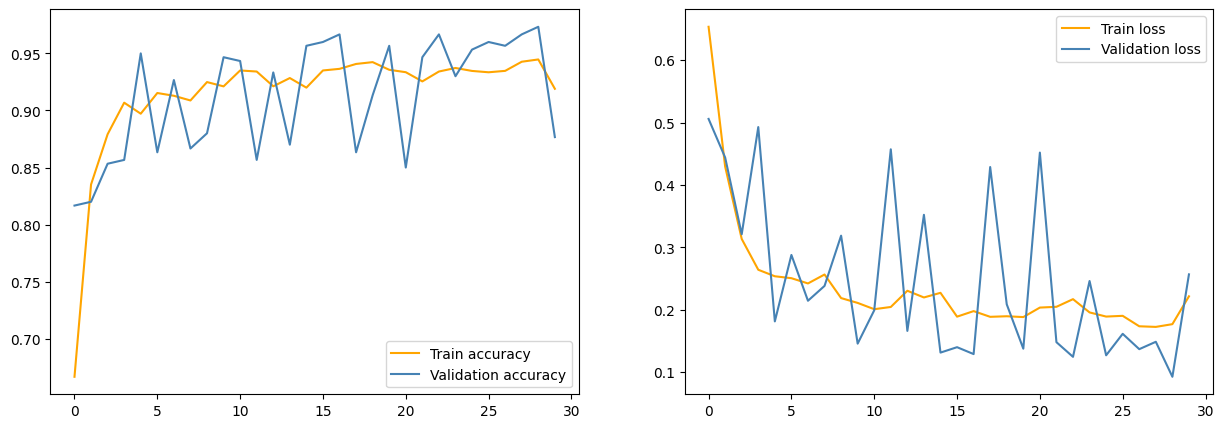

In [25]:
train_loop(30, 100, 0.001)

Epoch : 1, train accuracy : 0.9115431904792786, train loss : 0.23177354037761688
Epoch : 1, val_accuracy : 0.9600000381469727, val_loss : 0.11347682029008865
Epoch : 2, train accuracy : 0.9314403533935547, train loss : 0.2136300951242447
Epoch : 2, val_accuracy : 0.9724999666213989, val_loss : 0.18085375428199768
Epoch : 3, train accuracy : 0.9414403438568115, train loss : 0.16313371062278748
Epoch : 3, val_accuracy : 0.8350000381469727, val_loss : 0.608643651008606
Epoch : 4, train accuracy : 0.9464402794837952, train loss : 0.1444350928068161
Epoch : 4, val_accuracy : 0.9724999666213989, val_loss : 0.09191035479307175
Epoch : 5, train accuracy : 0.9522221684455872, train loss : 0.1590714156627655
Epoch : 5, val_accuracy : 0.9724999666213989, val_loss : 0.09977541863918304
Epoch : 6, train accuracy : 0.9476543068885803, train loss : 0.16265062987804413
Epoch : 6, val_accuracy : 0.9574999809265137, val_loss : 0.14158782362937927
Epoch : 7, train accuracy : 0.9581069946289062, train los

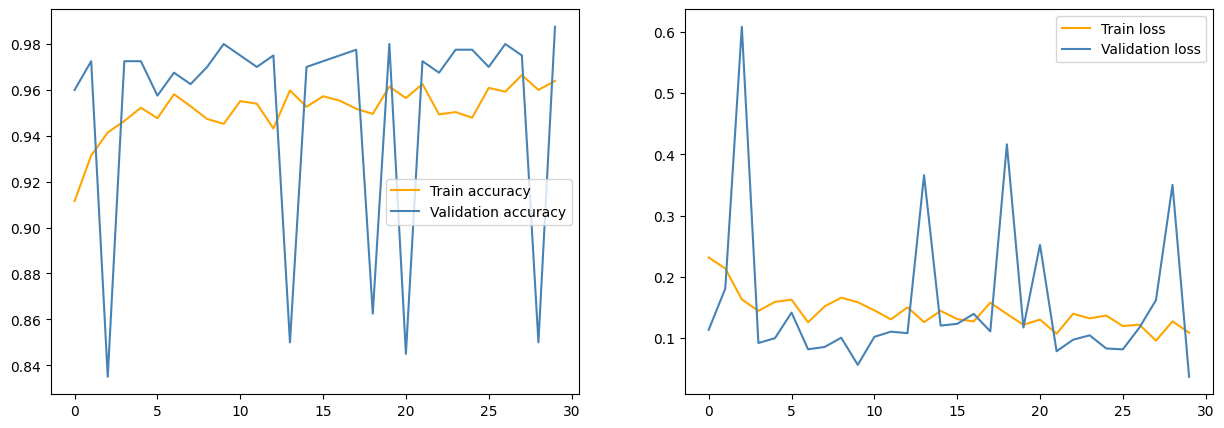

In [26]:
train_loop(30, 200, 0.001)

Epoch : 1, train accuracy : 0.9104112386703491, train loss : 0.2392919361591339
Epoch : 1, val_accuracy : 0.9509803652763367, val_loss : 0.1389269232749939
Epoch : 2, train accuracy : 0.9449037313461304, train loss : 0.16185727715492249
Epoch : 2, val_accuracy : 0.9656862616539001, val_loss : 0.10869383066892624
Epoch : 3, train accuracy : 0.9537445306777954, train loss : 0.13915666937828064
Epoch : 3, val_accuracy : 0.9607843160629272, val_loss : 0.1378311961889267
Epoch : 4, train accuracy : 0.951924741268158, train loss : 0.14077526330947876
Epoch : 4, val_accuracy : 0.9509803652763367, val_loss : 0.09656030684709549
Epoch : 5, train accuracy : 0.9554592967033386, train loss : 0.13020557165145874
Epoch : 5, val_accuracy : 0.9607843160629272, val_loss : 0.09445495158433914
Epoch : 6, train accuracy : 0.9649518728256226, train loss : 0.11304502189159393
Epoch : 6, val_accuracy : 0.9656862616539001, val_loss : 0.1017155572772026
Epoch : 7, train accuracy : 0.9625284075737, train loss :

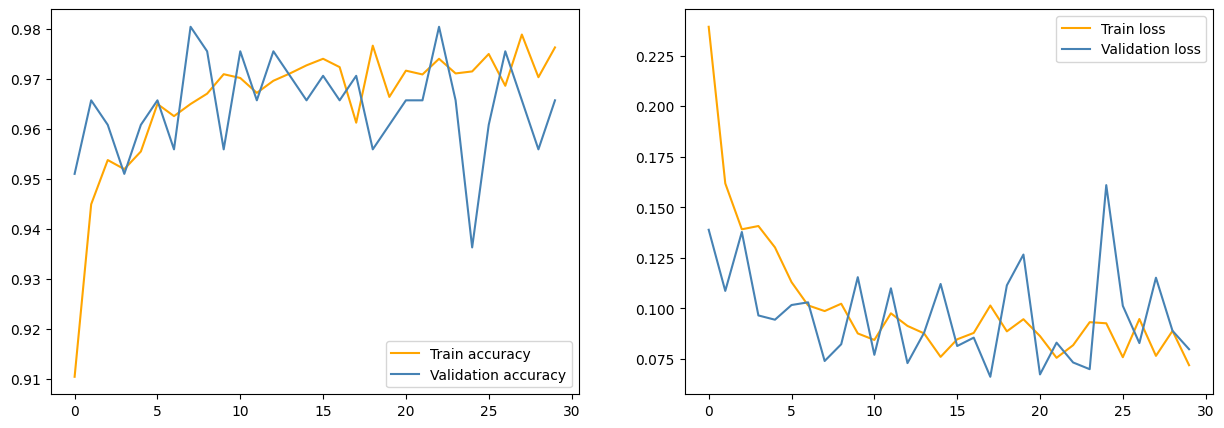

In [27]:
train_loop(30, 300, 0.001)

Epoch : 1, train accuracy : 0.7611110806465149, train loss : 0.9126604199409485
Epoch : 1, val_accuracy : 0.8066666722297668, val_loss : 0.46240293979644775
Epoch : 2, train accuracy : 0.8509368300437927, train loss : 0.4398746192455292
Epoch : 2, val_accuracy : 0.8499999642372131, val_loss : 0.3995780348777771
Epoch : 3, train accuracy : 0.8831154108047485, train loss : 0.32192710041999817
Epoch : 3, val_accuracy : 0.8600000143051147, val_loss : 0.3838615119457245
Epoch : 4, train accuracy : 0.9071677923202515, train loss : 0.24768562614917755
Epoch : 4, val_accuracy : 0.8500000238418579, val_loss : 0.3720676302909851
Epoch : 5, train accuracy : 0.885403037071228, train loss : 0.2740103304386139
Epoch : 5, val_accuracy : 0.8600000143051147, val_loss : 0.2919732928276062
Epoch : 6, train accuracy : 0.918409526348114, train loss : 0.22597138583660126
Epoch : 6, val_accuracy : 0.9500000476837158, val_loss : 0.1563931256532669
Epoch : 7, train accuracy : 0.914880096912384, train loss : 0.

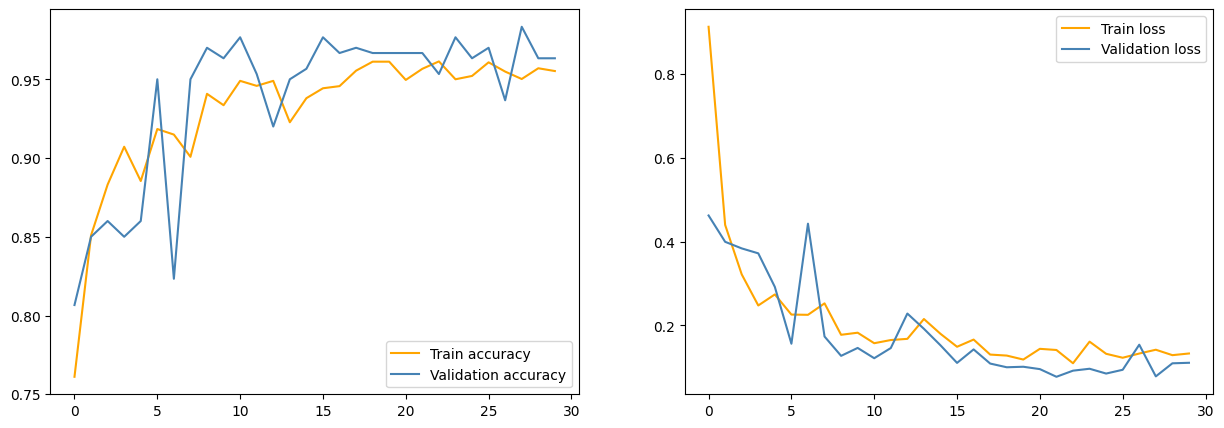

In [28]:
train_loop(30, 100, 0.005)

Epoch : 1, train accuracy : 0.9555555582046509, train loss : 0.13668707013130188
Epoch : 1, val_accuracy : 0.9774999618530273, val_loss : 0.07387150079011917
Epoch : 2, train accuracy : 0.959773600101471, train loss : 0.11978459358215332
Epoch : 2, val_accuracy : 0.9700000286102295, val_loss : 0.09969013929367065
Epoch : 3, train accuracy : 0.9456584453582764, train loss : 0.15613289177417755
Epoch : 3, val_accuracy : 0.9774999618530273, val_loss : 0.06202933192253113
Epoch : 4, train accuracy : 0.970329225063324, train loss : 0.09661250561475754
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.055775776505470276
Epoch : 5, train accuracy : 0.9711111187934875, train loss : 0.0840967446565628
Epoch : 5, val_accuracy : 0.9800000190734863, val_loss : 0.09521850943565369
Epoch : 6, train accuracy : 0.9675514698028564, train loss : 0.10430464148521423
Epoch : 6, val_accuracy : 0.862500011920929, val_loss : 0.20245309174060822
Epoch : 7, train accuracy : 0.9664403200149536, train l

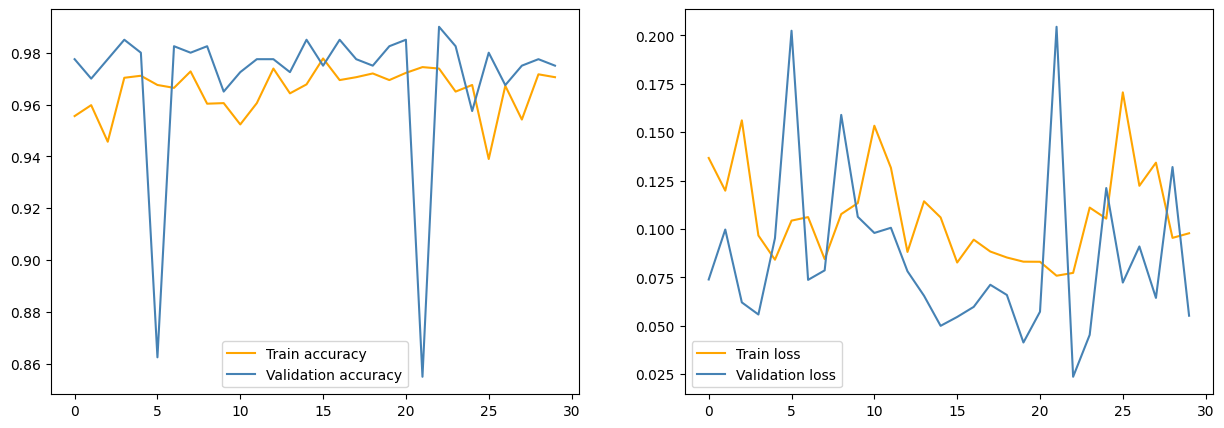

In [29]:
train_loop(30, 200, 0.005)

Epoch : 1, train accuracy : 0.9013210535049438, train loss : 0.2997466027736664
Epoch : 1, val_accuracy : 0.9558823704719543, val_loss : 0.13549892604351044
Epoch : 2, train accuracy : 0.9584383368492126, train loss : 0.14370901882648468
Epoch : 2, val_accuracy : 0.9411764740943909, val_loss : 0.14987576007843018
Epoch : 3, train accuracy : 0.9658617973327637, train loss : 0.10807301104068756
Epoch : 3, val_accuracy : 0.9558823704719543, val_loss : 0.17059728503227234
Epoch : 4, train accuracy : 0.9673753380775452, train loss : 0.10909336060285568
Epoch : 4, val_accuracy : 0.9460784196853638, val_loss : 0.13562935590744019
Epoch : 5, train accuracy : 0.9658617973327637, train loss : 0.09883075952529907
Epoch : 5, val_accuracy : 0.9509803652763367, val_loss : 0.12243135273456573
Epoch : 6, train accuracy : 0.9747506380081177, train loss : 0.08147009462118149
Epoch : 6, val_accuracy : 0.9754902124404907, val_loss : 0.07235874235630035
Epoch : 7, train accuracy : 0.9769728183746338, train

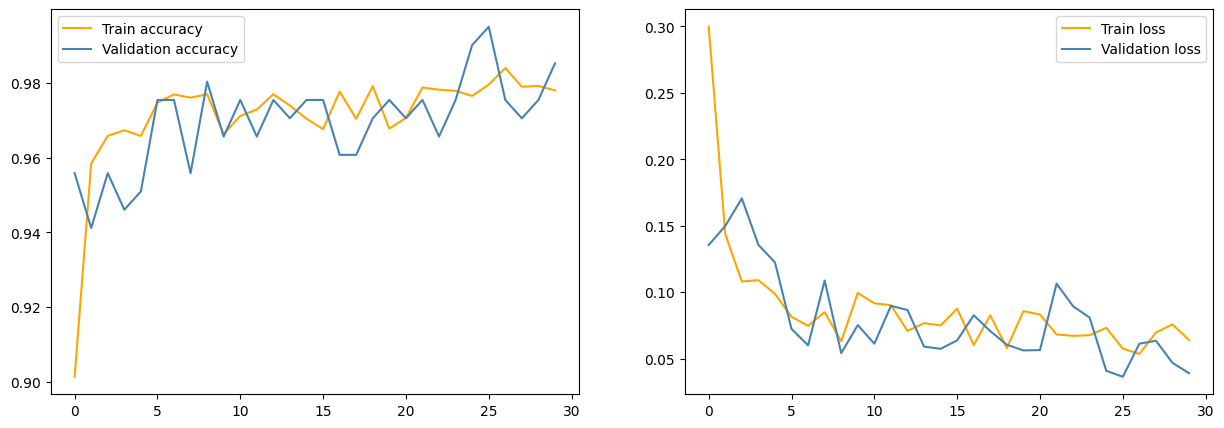

In [30]:
train_loop(30, 300, 0.005)

Epoch : 1, train accuracy : 0.9403485059738159, train loss : 0.15180791914463043
Epoch : 1, val_accuracy : 0.8933333158493042, val_loss : 0.2916271388530731
Epoch : 2, train accuracy : 0.96647047996521, train loss : 0.09534800052642822
Epoch : 2, val_accuracy : 0.9733333587646484, val_loss : 0.05717195197939873
Epoch : 3, train accuracy : 0.9676469564437866, train loss : 0.0949549674987793
Epoch : 3, val_accuracy : 0.9866666793823242, val_loss : 0.050301484763622284
Epoch : 4, train accuracy : 0.9694116711616516, train loss : 0.10292844474315643
Epoch : 4, val_accuracy : 0.9766666889190674, val_loss : 0.059156015515327454
Epoch : 5, train accuracy : 0.9672330021858215, train loss : 0.09695809334516525
Epoch : 5, val_accuracy : 0.9600000381469727, val_loss : 0.12515732645988464
Epoch : 6, train accuracy : 0.9676469564437866, train loss : 0.0924227312207222
Epoch : 6, val_accuracy : 0.9766666889190674, val_loss : 0.0840923935174942
Epoch : 7, train accuracy : 0.9646404981613159, train lo

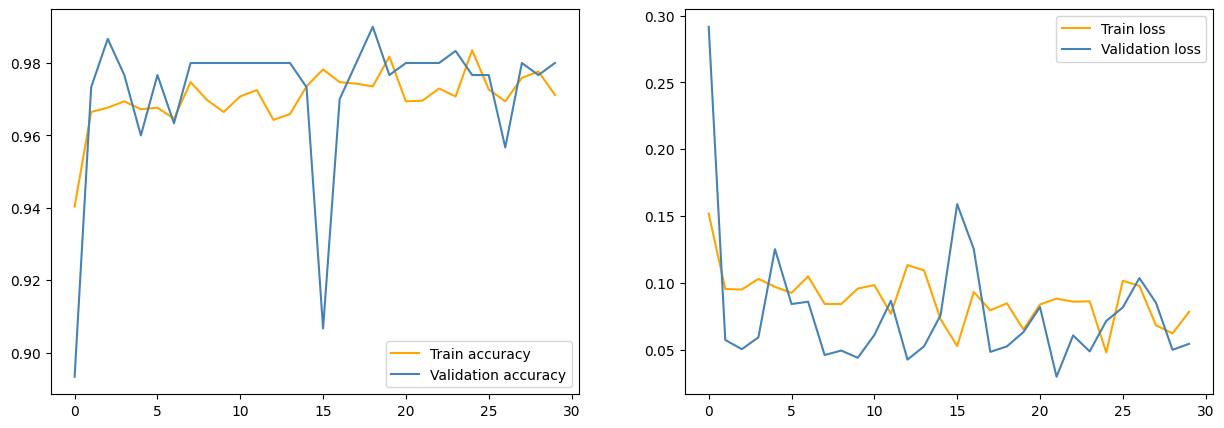

In [31]:
train_loop(30, 100, 0.007)

Epoch : 1, train accuracy : 0.9722222089767456, train loss : 0.08960439264774323
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.045149654150009155
Epoch : 2, train accuracy : 0.9698765277862549, train loss : 0.08228157460689545
Epoch : 2, val_accuracy : 0.9900000095367432, val_loss : 0.025594215840101242
Epoch : 3, train accuracy : 0.9719958901405334, train loss : 0.07939200103282928
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.053136441856622696
Epoch : 4, train accuracy : 0.9708847999572754, train loss : 0.07759439200162888
Epoch : 4, val_accuracy : 0.9774999618530273, val_loss : 0.04787099361419678
Epoch : 5, train accuracy : 0.971666693687439, train loss : 0.09136471152305603
Epoch : 5, val_accuracy : 0.9824999570846558, val_loss : 0.03629252314567566
Epoch : 6, train accuracy : 0.971666693687439, train loss : 0.0846923366189003
Epoch : 6, val_accuracy : 0.9824999570846558, val_loss : 0.06037912517786026
Epoch : 7, train accuracy : 0.9736626148223877, trai

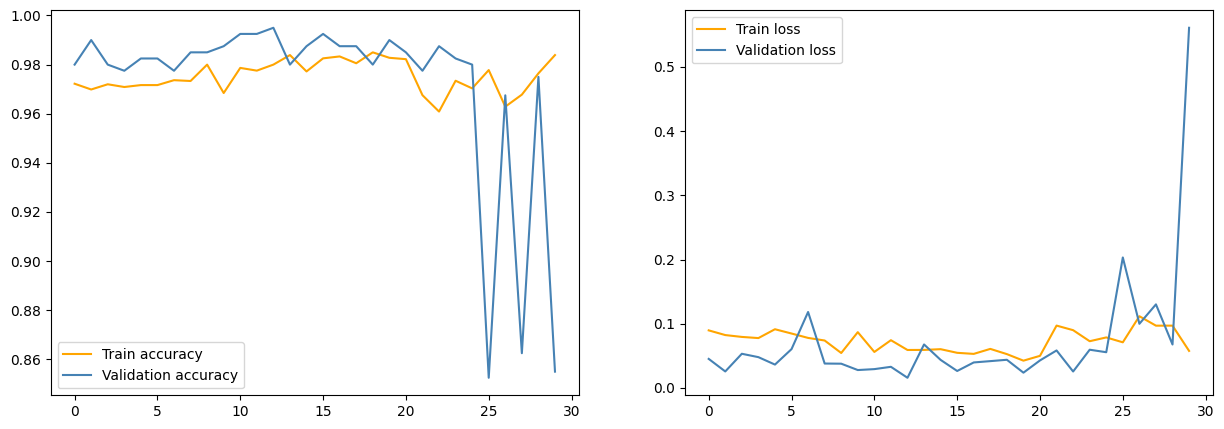

In [32]:
train_loop(30, 200, 0.007)

Epoch : 1, train accuracy : 0.9467716813087463, train loss : 0.1361895650625229
Epoch : 1, val_accuracy : 0.9607843160629272, val_loss : 0.13122545182704926
Epoch : 2, train accuracy : 0.96677166223526, train loss : 0.09811104834079742
Epoch : 2, val_accuracy : 0.970588207244873, val_loss : 0.12167996168136597
Epoch : 3, train accuracy : 0.9728828072547913, train loss : 0.10683447122573853
Epoch : 3, val_accuracy : 0.9558823704719543, val_loss : 0.11838163435459137
Epoch : 4, train accuracy : 0.9652581214904785, train loss : 0.10560551285743713
Epoch : 4, val_accuracy : 0.9656862616539001, val_loss : 0.05974522605538368
Epoch : 5, train accuracy : 0.9747987985610962, train loss : 0.08306316286325455
Epoch : 5, val_accuracy : 0.9656862616539001, val_loss : 0.10534155368804932
Epoch : 6, train accuracy : 0.978792667388916, train loss : 0.06369969993829727
Epoch : 6, val_accuracy : 0.9754902124404907, val_loss : 0.05715646967291832
Epoch : 7, train accuracy : 0.9812641739845276, train los

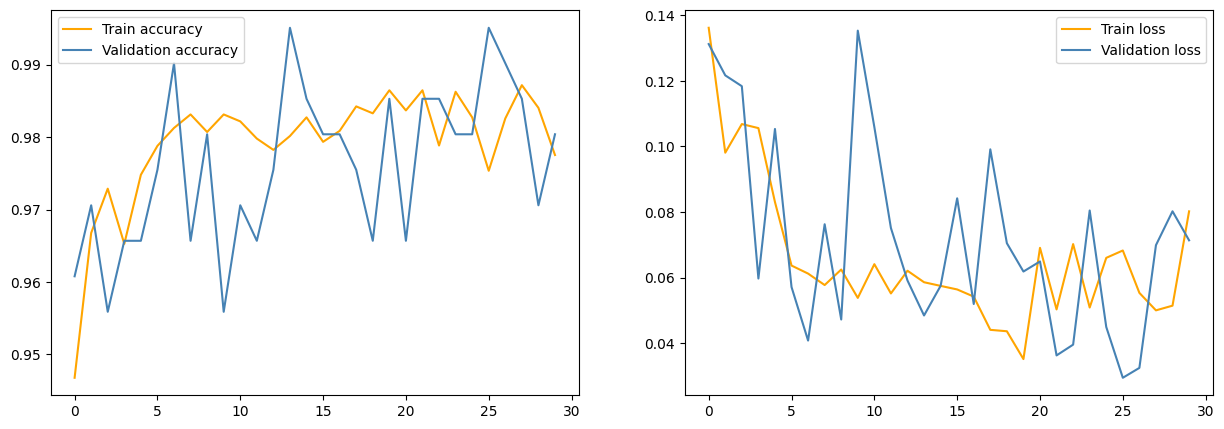

In [33]:
train_loop(30, 300, 0.007)

Epoch : 1, train accuracy : 0.9834864735603333, train loss : 0.05984281748533249
Epoch : 1, val_accuracy : 0.9852941036224365, val_loss : 0.06351973861455917
Epoch : 2, train accuracy : 0.9825765490531921, train loss : 0.05933881178498268
Epoch : 2, val_accuracy : 0.9901960492134094, val_loss : 0.03771791607141495
Epoch : 3, train accuracy : 0.9832851886749268, train loss : 0.047643277794122696
Epoch : 3, val_accuracy : 0.9901960492134094, val_loss : 0.024926647543907166
Epoch : 4, train accuracy : 0.9844444394111633, train loss : 0.04375595599412918
Epoch : 4, val_accuracy : 0.9901960492134094, val_loss : 0.03134993836283684
Epoch : 5, train accuracy : 0.9842432141304016, train loss : 0.05303066968917847
Epoch : 5, val_accuracy : 1.0, val_loss : 0.015592142939567566
Epoch : 6, train accuracy : 0.9883333444595337, train loss : 0.029892753809690475
Epoch : 6, val_accuracy : 0.9852941036224365, val_loss : 0.0598103404045105
Epoch : 7, train accuracy : 0.9855555295944214, train loss : 0.0

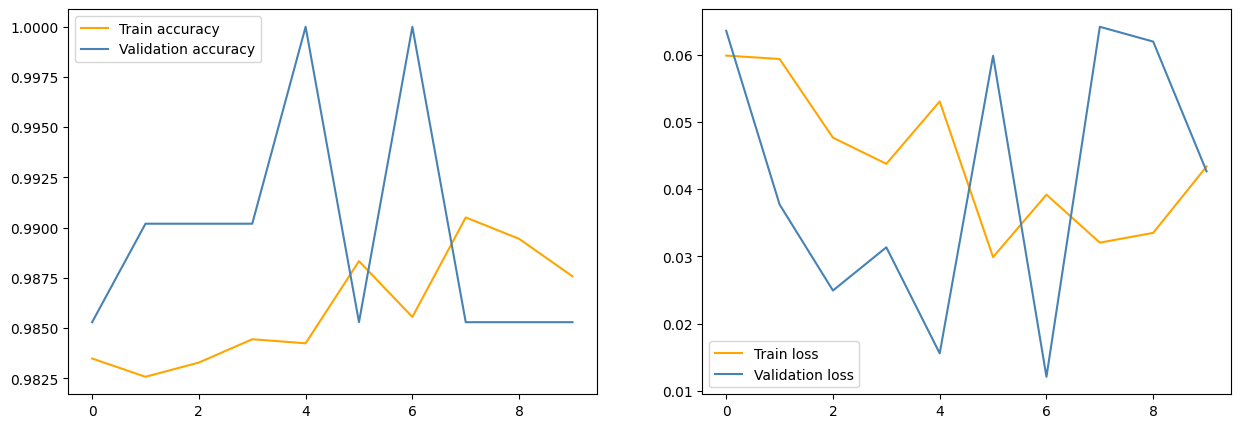

In [34]:
train_loop(10, 300, 0.001)

Сохранение результатов:

In [35]:
bears_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size=300,
                                          shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        bears_probs += list(zip(list(fileid), preds_list))
bears_probs.sort(key = lambda x : int(x[0]))
bears_probs[:10]

[(tensor(0), 0.9923742413520813),
 (tensor(0), 1.0412859410280362e-06),
 (tensor(0), 0.04250796511769295),
 (tensor(0), 0.1695953756570816),
 (tensor(0), 3.653705249462291e-08),
 (tensor(0), 7.2719716533165e-12),
 (tensor(0), 0.0006182633223943412),
 (tensor(0), 0.9887080192565918),
 (tensor(0), 3.9321826350580125e-10),
 (tensor(0), 4.2649571696529165e-06)]

In [36]:
idx = list(i for i in range(len(bears_probs)))
prob = list(map(lambda x: x[1],bears_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,9.923742e-01
1,1,1.041286e-06
2,2,4.250797e-02
3,3,1.695954e-01
4,4,3.653705e-08
...,...,...
198,198,9.998903e-01
199,199,1.000000e+00
200,200,9.999123e-01
201,201,9.997683e-01


Запуск модели на тестовых данных

In [37]:
mymodel = CNN()
mymodel.load_state_dict(torch.load(os.path.join("/content", "weight.pt")))

FileNotFoundError: ignored

In [ ]:
id_list = []
class_ = {0: 'brown bear', 1: 'polar bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = X_test_list[i]
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)